In [1]:
import requests
import time
import json
import pandas as pd
import numpy as np
from warnings import warn
import re
import pickle
import os
from datetime import date, datetime
import matplotlib.pyplot as plt

## Исследование заработной платы по описанию вакансии
**Задача:** выявить факторы, которые больше всего влияют на размер заработной платы.
**Ограничения:**
- только вакансии со словом "аналитик"
- только Москва

На этом занятии будем исследовать данные с HH. Для этого нам пригодится [HH API](https://dev.hh.ru/).

#### Получим ID всех имеющихся вакансий

In [20]:
os.mkdir('tmp')

In [2]:
params = {
    'text': 'NAME:Аналитик',  # в имени должно быть слово "Аналитик"
    'area': 1,  # поиск ощуществляется по вакансиям города Москва
    'page': 0,  # индекс страницы поиска на HH
    'per_page': 100,  # кол-во вакансий на 1 странице
    'only_with_salary': 'true'  # берем только те вакансии, где указана заработная плата
}

ids = []

while True:
    response = requests.get('https://api.hh.ru/vacancies', params)

    if response.status_code == 200:
        response_content = response.content.decode()
        response_dict = json.loads(response_content)

        ids_ = [item['id'] for item in response_dict['items']]
        ids_count = len(ids_)

        if ids_count == 0:
            break
        else:
            ids.extend(ids_)
            print(f'Page {params["page"]} successfully processed...')
            params['page'] += 1
            time.sleep(0.5)
    else:
        warn(f'Something went wrong, response status code is {response.status_code}')
    
    response.close()

Page 0 successfully processed...
Page 1 successfully processed...
Page 2 successfully processed...
Page 3 successfully processed...
Page 4 successfully processed...


KeyboardInterrupt: 

In [22]:
with open('tmp/ids.pickle', 'wb') as outfile:
    pickle.dump(ids, outfile)

In [23]:
del ids

In [24]:
with open('tmp/ids.pickle', 'rb') as infile:
    ids = pickle.load(infile)

In [26]:
ids

['88348260',
 '88381163',
 '88284712',
 '87861598',
 '88272144',
 '88292196',
 '88519680',
 '87523367',
 '88394182',
 '88530112',
 '88524223',
 '88309989',
 '88333712',
 '87336369',
 '87861603',
 '88228362',
 '84815371',
 '87369159',
 '88460381',
 '88116976',
 '87965025',
 '88210759',
 '88242128',
 '87654336',
 '88522598',
 '86739027',
 '88088813',
 '87422522',
 '88061484',
 '88430894',
 '88414939',
 '88061920',
 '88333675',
 '88457815',
 '87991442',
 '86552792',
 '87859398',
 '88144765',
 '88248401',
 '87944405',
 '88391456',
 '88532944',
 '88417300',
 '88347802',
 '87987839',
 '88417107',
 '87800955',
 '87692174',
 '88415381',
 '88172774',
 '88457955',
 '87992367',
 '88071616',
 '87993007',
 '88511070',
 '87659351',
 '87716498',
 '87248433',
 '87805089',
 '88248548',
 '88351774',
 '86912417',
 '88364684',
 '88030614',
 '88307494',
 '88539001',
 '88532045',
 '88330106',
 '88367053',
 '83080777',
 '87983502',
 '88501619',
 '87972129',
 '87878234',
 '88003511',
 '88309151',
 '88232907',

#### Получим информацию о каждой вакансии

In [27]:
ids[0]

'88348260'

In [28]:
response = requests.get('https://api.hh.ru/vacancies/88348260')

if response.status_code == 200:
    response_content = response.content.decode()
    response_dict = json.loads(response_content)
else:
    warn(f'Something went wrong, response status code is {response.status_code}')

In [30]:
vacancies = []

for id_ in ids:
    host = f'https://api.hh.ru/vacancies/{id_}'

    response = requests.get(host)

    if response.status_code == 200:
        response_content = response.content.decode()
        response_dict = json.loads(response_content)
        vacancies.append(response_dict)
    else:
        warn(f'Something went wrong, response status code is {response.status_code}')

    time.sleep(0.5)

KeyboardInterrupt: 

In [7]:
salary_params = ['from', 'to', 'currency', 'gross']

def process_vacancy(vacancy: dict) -> dict:
    
    vacancy_processed = {}
    vacancy_processed['id'] = vacancy.get('id')

    # salary
    salary_exists = vacancy.get('salary') is not None
    
    for sp in salary_params:
        if salary_exists:
            vacancy_processed[f'salary_{sp}'] = vacancy['salary'].get(sp)
        else:
            vacancy_processed[f'salary_{sp}'] = None

    # address
    address = vacancy.get('address')

    if address is None:
        vacancy_processed['lat'] = None
        vacancy_processed['lng'] = None
    else:
        vacancy_processed['lat'] = address['lat']
        vacancy_processed['lng'] = address['lng']

    # experience
    experience = vacancy.get('experience')

    if experience is None:
        vacancy_processed['experience'] = None
    else:
        vacancy_processed['experience'] = experience['id']

    # key_skills
    key_skills = vacancy.get('key_skills')

    if key_skills is None:
        vacancy_processed['key_skills'] = None
    else:
        if len(key_skills) == 0:
            vacancy_processed['key_skills'] = None
        else:
            vacancy_processed['key_skills'] = [skill['name'] for skill in key_skills]

    return vacancy_processed

In [8]:
vacancies_processed = [process_vacancy(v) for v in vacancies]

#### Перейдем к pandas

In [2]:
with open('tmp/vacancies.pickle', 'rb') as infile:
    vacancies = pickle.load(infile)

In [9]:
vacancies_processed = [process_vacancy(v) for v in vacancies]

In [2]:
vacancies_df = pd.read_excel('tmp/vacancies_df.xlsx').dropna(subset=['id', 'salary_gross'])
vacancies_df.head()

id  response_letter_required  salary_from  salary_to salary_currency  \
0  88603203                      True          NaN    60000.0             RUR   
1  81879828                     False     300000.0        NaN             RUR   
2  88629159                     False          NaN    56000.0             RUR   
3  88587403                     False          NaN    70000.0             RUR   
4  88564624                     False      80000.0        NaN             RUR   

   salary_gross        lat        lng          experience  \
0          True  55.746593  37.537371           Нет опыта   
1          True        NaN        NaN       От 3 до 6 лет   
2          True        NaN        NaN           Нет опыта   
3          True  55.971663  37.491602           Нет опыта   
4         False  55.803479  37.390514  От 1 года до 3 лет   

                                          key_skills  
0                                  ['SQL', 'Python']  
1                                                 []  
2                                                 []  
3                                                 []  
4  ['SQL', 'Power BI', 'MS PowerPoint', 'Работа с...

In [38]:
vacancies_df.loc[vacancies_df['salary_to'].isna(), 'salary_currency'].value_counts()

salary_currency
RUR    676
USD     10
EUR      2
Name: count, dtype: int64

In [49]:
vacancies_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1734 entries, 0 to 1745
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               1734 non-null   object 
 1   salary_from      1398 non-null   float64
 2   salary_to        1046 non-null   float64
 3   salary_currency  1734 non-null   object 
 4   salary_gross     1734 non-null   object 
 5   lat              953 non-null    float64
 6   lng              953 non-null    float64
 7   experience       1734 non-null   object 
 8   key_skills       1180 non-null   object 
dtypes: float64(4), object(5)
memory usage: 135.5+ KB


In [ ]:
# ЗАМЕТКА
# можно ли просто удалить все строки с пропущенными значениями?

In [12]:
vacancies_df.dropna().shape

(288, 9)

In [ ]:
# просто убрать все строки с NA не получится

#### Разберемся с таргетом

In [13]:
vacancies_df.head()

id  salary_from  salary_to salary_currency salary_gross        lat  \
0  88603203          NaN    60000.0             RUR         True  55.746593   
1  81879828     300000.0        NaN             RUR         True        NaN   
2  88629159          NaN    56000.0             RUR         True        NaN   
3  88587403          NaN    70000.0             RUR         True  55.971663   
4  88564624      80000.0        NaN             RUR        False  55.803479   

         lng    experience                                         key_skills  
0  37.537371  noExperience                                      [SQL, Python]  
1        NaN  between3And6                                               None  
2        NaN  noExperience                                               None  
3  37.491602  noExperience                                               None  
4  37.390514  between1And3  [SQL, Power BI, MS PowerPoint, Работа с больши...

In [15]:
(vacancies_df['salary_from'].notna() & vacancies_df['salary_to'].notna()).sum()

710

In [ ]:
# ЧТО ДЕЛАТЬ С salary_from и salary_to?

#1 Посчитать среднее значение
# + получаем разумную метрику
# - остается слишком мало наблюдений

#2 Заместить пропущенные значения
#2.1 Считаем, что одна метрика может заменить другую
# +это просто сделать
# -нарушается консистентность таргета

#2.2 Экстраполировать пропущенное значение исходя из закономерностей в данных
# -сложнее
# -мы "придумываем" таргет сами, НО
# +у нас есть возможность контролировать "качество" этого таргета
# +самый интересный вариант

# РЕШЕНИЕ: попробуем восстановить пропущенные значения с помощью ML
# можем перебрать несколько моделей и выбрать для восстановления ту, которая будет предсказывать лучше
# LR, RF, GB

#### Немного про .itertuples()

In [17]:
def convert_gross(series: pd.Series) -> float:
    if series['salary_gross']:
        return series.iloc[0] * 0.87
    else:
        return series.iloc[0]

In [32]:
from collections import namedtuple

def convert_gross_(series: namedtuple) -> float:
    if series.salary_gross:
        return series[1] * 0.87
    else:
        return series[1]

In [31]:
%%timeit

_ = vacancies_df[['salary_from', 'salary_gross']].apply(convert_gross, axis=1)

5.88 ms ± 45.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [33]:
%%timeit

_ = [convert_gross_(ntpl) for ntpl in vacancies_df[['salary_from', 'salary_gross']].itertuples()]

558 µs ± 7.38 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [29]:
for ntpl in vacancies_df[['salary_from', 'salary_gross']].itertuples():
    print(ntpl)

Pandas(Index=0, salary_from=nan, salary_gross=True)
Pandas(Index=1, salary_from=300000.0, salary_gross=True)
Pandas(Index=2, salary_from=nan, salary_gross=True)
Pandas(Index=3, salary_from=nan, salary_gross=True)
Pandas(Index=4, salary_from=80000.0, salary_gross=False)
Pandas(Index=5, salary_from=74000.0, salary_gross=True)
Pandas(Index=6, salary_from=45000.0, salary_gross=False)
Pandas(Index=7, salary_from=20000.0, salary_gross=False)
Pandas(Index=8, salary_from=80000.0, salary_gross=False)
Pandas(Index=9, salary_from=39000.0, salary_gross=False)
Pandas(Index=10, salary_from=60000.0, salary_gross=False)
Pandas(Index=11, salary_from=60000.0, salary_gross=False)
Pandas(Index=12, salary_from=116000.0, salary_gross=False)
Pandas(Index=13, salary_from=70000.0, salary_gross=True)
Pandas(Index=14, salary_from=50000.0, salary_gross=True)
Pandas(Index=15, salary_from=nan, salary_gross=True)
Pandas(Index=16, salary_from=250000.0, salary_gross=True)
Pandas(Index=17, salary_from=350000.0, salary_

#### Продолжаем

In [3]:
from currency_converter import CurrencyConverter
from collections import namedtuple

converter = CurrencyConverter()
rate_date = date(2022, 2, 1)

def convert_currency(ntpl: namedtuple) -> float:
    if ntpl.salary_currency is None:
        return None
    elif ntpl.salary_currency != 'RUR':
        return converter.convert(ntpl[1], ntpl.salary_currency, 'RUB', rate_date)
    else:
        return ntpl[1]

In [4]:
# DO NOT RUN TWICE
vacancies_df['salary_from'] = [convert_currency(ntpl) for ntpl in vacancies_df[['salary_from', 'salary_currency']].itertuples()]
vacancies_df['salary_to'] = [convert_currency(ntpl) for ntpl in vacancies_df[['salary_to', 'salary_currency']].itertuples()]

In [5]:
vacancies_df.loc[vacancies_df['salary_gross'], 'salary_from'] = vacancies_df.loc[vacancies_df['salary_gross'], 'salary_from'] * 0.87

#### Восполним пропущенный таргет
**Алгоритм**

1. Импортировать модель;
2. Создать экземпляр класса;
3. Разбить данне на train и test;
4. Применить метод fit (обучить модель) на train;
5. Проверить качество на test;
6. Сохранить метрику для сравнения;
7. Сравнить с baseline.

In [6]:
target_data = vacancies_df.loc[
    vacancies_df['salary_from'].notna() & vacancies_df['salary_to'].notna(),
    ['salary_from', 'salary_to']
].reset_index(drop=True)

In [53]:
target_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701 entries, 0 to 700
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   salary_from  701 non-null    float64
 1   salary_to    701 non-null    float64
dtypes: float64(2)
memory usage: 11.1 KB


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score

models = {
    'linear regression': LinearRegression,
    'random forest': RandomForestRegressor,
    'gradient boosting': GradientBoostingRegressor
}

In [15]:
X = target_data[['salary_from']]
y = target_data[['salary_to']]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

In [20]:
# проверим качество на нескольких итерация
NITER = 100

qualities_iters = []

for i in range(NITER):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)
    
    qualities = []

    for model_name, model in models.items():
        model_instance = model()
        model_instance.fit(X_train, y_train)
    
        predict = model_instance.predict(X_test)
        quality = r2_score(predict, y_test)
    
        qualities.append({'model_name': model_name, 'quality': quality})

    qualities_iters.extend(qualities)

/Users/iadovgopolyi/teaching/lib/python3.11/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/iadovgopolyi/teaching/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/iadovgopolyi/teaching/lib/python3.11/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/iadovgopolyi/teaching/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was

In [21]:
qualities_df = pd.DataFrame(qualities)

In [17]:
qualities_df = pd.DataFrame(qualities)
qualities_df

model_name   quality
0  linear regression  0.729353
1      random forest  0.626660
2  gradient boosting  0.638343

Попробуем baseline:

In [26]:
NITER = 100

qualities_baseline = []

for i in range(NITER):
    train, test = train_test_split(target_data, train_size=0.7)

    mean_ratio = (train['salary_to'] / train['salary_from']).mean()
    predict = test['salary_from'] * mean_ratio
    
    qualities_baseline.append(['baseline', r2_score(predict, test['salary_to'])])

qualities_baseline_df = pd.DataFrame(qualities_baseline, columns=['model_name', 'quality'])

In [27]:
qualities_final = pd.concat([qualities_df, qualities_baseline_df])

In [30]:
qualities_final.groupby(['model_name']).mean().sort_values(by='quality', ascending=False)

quality
model_name                 
baseline           0.745356
random forest      0.709148
gradient boosting  0.695165
linear regression  0.682854

РЕШЕНИЕ: оказывается, для восстановления пропущенных значений достаточно простой эвристики.

**Максима:** стремимся к наилучшему качеству при наименьшем количестве параметров.

In [8]:
vacancies_restored = vacancies_df.copy()

mean_ratio = (target_data['salary_to'] / target_data['salary_from']).mean()

# salary_to
vacancies_restored.loc[
    vacancies_restored['salary_to'].isna(), 'salary_to'
] = vacancies_restored.loc[
    vacancies_restored['salary_to'].isna(), 'salary_from'
] * mean_ratio

# salary_from
vacancies_restored.loc[
    vacancies_restored['salary_from'].isna(), 'salary_from'
] = vacancies_restored.loc[
    vacancies_restored['salary_from'].isna(), 'salary_to'
] / mean_ratio

# target
vacancies_restored['target'] = vacancies_restored[['salary_from', 'salary_to']].values.mean(axis=1)

#### Займемся моделью: добавим фичи

- response_letter_required: не берем, поскольку 1) мало наблюдений с категорией 1 и 2) разница в таргете между двумя группами не сильно значимая;
- address_lat и address_lng: берем и переводим в административные округа, т. к. согласно карте ЗП на юго-западе в среднем выше;
- key_skills:

In [56]:
vacancies_restored.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1734 entries, 0 to 1745
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        1734 non-null   float64
 1   response_letter_required  1734 non-null   float64
 2   salary_from               1734 non-null   float64
 3   salary_to                 1734 non-null   float64
 4   salary_currency           1734 non-null   object 
 5   salary_gross              1734 non-null   float64
 6   address_lat               953 non-null    float64
 7   address_lng               953 non-null    float64
 8   key_skills                1734 non-null   object 
 9   target                    1734 non-null   float64
dtypes: float64(8), object(2)
memory usage: 213.6+ KB


In [57]:
vacancies_restored.head()

id  response_letter_required    salary_from      salary_to  \
0  88603203.0                       1.0   39967.991412   60000.000000   
1  81879828.0                       0.0  261000.000000  391813.534950   
2  88629159.0                       0.0   37303.458651   56000.000000   
3  88587403.0                       0.0   46629.323314   70000.000000   
4  88564624.0                       0.0   80000.000000  120096.102667   

  salary_currency  salary_gross  address_lat  address_lng  \
0             RUR           1.0    55.746593    37.537371   
1             RUR           1.0          NaN          NaN   
2             RUR           1.0          NaN          NaN   
3             RUR           1.0    55.971663    37.491602   
4             RUR           0.0    55.803479    37.390514   

                                          key_skills         target  
0                                  ['SQL', 'Python']   49983.995706  
1                                                 []  326406.767475  
2                                                 []   46651.729326  
3                                                 []   58314.661657  
4  ['SQL', 'Power BI', 'MS PowerPoint', 'Работа с...  100048.051333

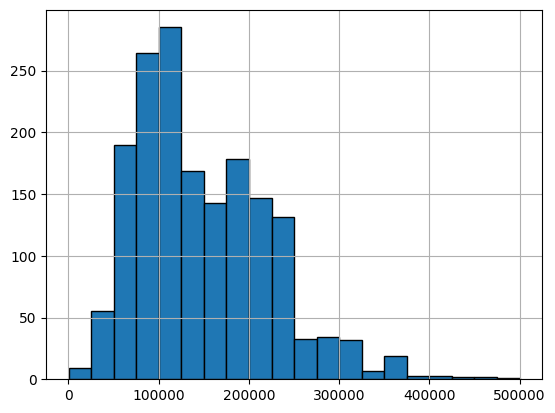

In [26]:
vacancies_restored['target'].hist(edgecolor='black', bins=20);

In [23]:
vacancies_model = vacancies_restored.copy()

# response_letter_required
vacancies_model['response_letter_required'] = vacancies_model['response_letter_required'].astype(int)

# key_skills
def list_parser(string: str) -> list:
    skills = [skill.strip("'") for skill in string.strip('[]').split(', ') if skill != '']

    return skills

# key_skills
vacancies_model['key_skills'] = vacancies_model['key_skills'].map(list_parser)

# address_lat и address_lng
vacancies_model['address_exists'] = vacancies_model['lat'].notna().astype(int)

In [10]:
vacancies_model.groupby(['response_letter_required'])['target'].mean()

response_letter_required
0    152397.519827
1    130688.351244
Name: target, dtype: float64

In [11]:
vacancies_model.groupby(['response_letter_required'])['target'].median()

response_letter_required
0    135000.000000
1    113311.994856
Name: target, dtype: float64

In [ ]:
#1 выдвигали H0 (нулевая гипотеза): все различия случайны, на самом деле их нет
#2 определяли распределение разности, если все различия на самом деле случайны
#3 если все случайно, то насколько вероятно получить наблюдаемое значение разницы?
#4 делаем вывод на основании полученного значения вероятности

# ранее пункты 2 и 3 выполнялись с помощью вычислительного эксперимента, теперь это сделает за статистический тест

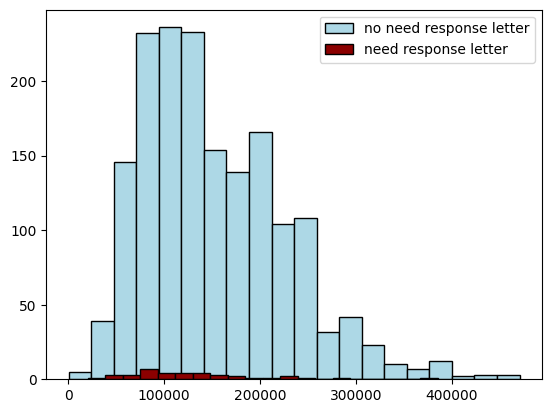

In [12]:
cmapper = {
    0: 'lightblue',
    1: 'darkred',
}

label_mapper = {
    0: 'no need response letter',
    1: 'need response letter',
}

fig, ax = plt.subplots()

for name, df in vacancies_model.groupby('response_letter_required'):
    color = cmapper[name]
    label = label_mapper[name]
    ax.hist(df['target'], bins=20, edgecolor='black', color=color, label=label)

ax.legend();  # можно по оси Y показывать не абсолютные значения, а относительные

In [25]:
from scipy import stats

# для тестирования разности показателя X в двух группах самым универсальным является непараметрический критерий Манна-Уитни

stats.mannwhitneyu(
    vacancies_model.loc[vacancies_model['response_letter_required'] == 1, 'target'],
    vacancies_model.loc[vacancies_model['response_letter_required'] == 0, 'target']
).pvalue

# РАНЕЕ: если все случайно, то насколько вероятно получить наблюдаемое значение разницы?
# ответ: pvalue

0.04637407157176294

In [71]:
vacancies_model['response_letter_required'].value_counts()

response_letter_required
0    1696
1      38
Name: count, dtype: int64

**address_exists**

In [24]:
vacancies_model.groupby(['address_exists'])['target'].median()

address_exists
0    154239.985809
1    128533.321508
Name: target, dtype: float64

In [26]:
stats.mannwhitneyu(
    vacancies_model.loc[vacancies_model['address_exists'] == 1, 'target'],
    vacancies_model.loc[vacancies_model['address_exists'] == 0, 'target']
).pvalue

6.4107014294443716e-06

#### key_skills
- посмотреть наиболее часто встречающиеся скиллы;
- использовать каждый в качестве бинарной переменной.

In [14]:
skills_flatten = pd.Series([skill for skills in vacancies_model['key_skills'].tolist() for skill in skills])
skills_counts = skills_flatten.value_counts()

In [15]:
def check_skill(data: pd.DataFrame, skill: str) -> dict:
    mask = data['key_skills'].map(lambda skills: skill in skills)
    target_yes = data.loc[mask, 'target']
    target_no = data.loc[~mask, 'target']

    # compute difference
    diff = target_yes.median() - target_no.median()

    # check pvalue
    mv_object = stats.mannwhitneyu(target_yes, target_no)
    pvalue = mv_object.pvalue

    skill_stats = {
        'skill': skill,
        'diff': diff,
        'pvalue': pvalue
    }

    return skill_stats

In [16]:
skills_to_check = skills_counts.index[skills_counts.values >= 50].tolist()
skills_stats = [check_skill(vacancies_model[['key_skills', 'target']], skill) for skill in skills_to_check]

skills_stats_df = pd.DataFrame(skills_stats)
skills_stats_df['pvalue_adjusted'] = skills_stats_df['pvalue'] * len(skills_to_check)

In [20]:
len(skills_to_check)

35

In [17]:
CUTOFF = 0.05

skills_stats_df[skills_stats_df['pvalue_adjusted'] <= CUTOFF].sort_values(by=['diff'], ascending=False).iloc[:10]

skill          diff        pvalue  \
28                            REST  98234.139058  3.868748e-15   
10                             UML  86466.678492  3.256531e-17   
22                  Atlassian Jira  84066.206252  2.700652e-10   
7                 Системный анализ  81466.678492  3.712211e-17   
5                             BPMN  76050.731223  3.012761e-16   
18          ERP-системы на базе 1С  61866.188514  1.802280e-08   
1                              SQL  61466.678492  3.092967e-17   
11  Постановка задач разработчикам  57701.205916  1.230255e-10   
9   Разработка технических заданий  48918.383539  2.442066e-08   
4                    Бизнес-анализ  45000.000000  9.333654e-08   

    pvalue_adjusted  
28     1.354062e-13  
10     1.139786e-15  
22     9.452282e-09  
7      1.299274e-15  
5      1.054466e-14  
18     6.307980e-07  
1      1.082538e-15  
11     4.305892e-09  
9      8.547232e-07  
4      3.266779e-06

In [19]:
skills_stats_df[skills_stats_df['skill'] == 'Python']

skill          diff    pvalue  pvalue_adjusted
17  Python  30811.212346  0.017779         0.622265

In [18]:
skills_stats_df[skills_stats_df['pvalue_adjusted'] <= CUTOFF].sort_values(by=['diff']).iloc[:10]

skill          diff        pvalue  \
8                              MS Excel -41812.327345  3.008995e-14   
20                         Анализ рынка -40289.107506  1.916091e-07   
12                        MS PowerPoint -40000.000000  3.387953e-10   
3   Работа с большим объемом информации -35763.750000  3.125866e-09   
34                                Excel -33733.503193  2.465271e-06   
13             Сбор и анализ информации -32350.000000  6.237591e-05   
32               Подготовка презентаций -32173.342794  2.429562e-04   
0                Аналитическое мышление -28160.005321  4.583830e-09   
14           Аналитические исследования -25188.005144  1.426234e-03   
2                         Анализ данных -15000.000000  5.797419e-04   

    pvalue_adjusted  
8      1.053148e-12  
20     6.706320e-06  
12     1.185784e-08  
3      1.094053e-07  
34     8.628448e-05  
13     2.183157e-03  
32     8.503469e-03  
0      1.604340e-07  
14     4.991819e-02  
2      2.029097e-02

In [36]:
skills_stats_df['signif'] = skills_stats_df['pvalue_adjusted'] < CUTOFF
skills_important = skills_stats_df.loc[skills_stats_df['signif'], 'skill'].values

In [37]:
skills_important

array(['Аналитическое мышление', 'SQL', 'Анализ данных',
       'Работа с большим объемом информации', 'Бизнес-анализ', 'BPMN',
       'Системный анализ', 'MS Excel', 'Разработка технических заданий',
       'UML', 'Постановка задач разработчикам', 'MS PowerPoint',
       'Сбор и анализ информации', 'Аналитические исследования',
       'ERP-системы на базе 1С', 'Анализ рынка', 'Atlassian Jira', 'REST',
       'Подготовка презентаций', 'Excel'], dtype=object)

#### Подготовим фичи

In [29]:
import re

from string import punctuation
from transliterate import translit

punctuation = f'[{re.escape(punctuation.replace("_", ""))}]'
punctuation_re = re.compile(punctuation)

def fix_string(string: str) -> str:
    string = translit(string, 'ru', reversed=True)
    string = punctuation_re.sub('', string).lower()

    return '_'.join([word[:4] for word in string.split()])

def get_mapper(vector) -> dict:
    return {string: fix_string(string) for string in set(vector)}

In [63]:
features = ['target', 'address_exists', 'experience', 'key_skills']

model_data = vacancies_model[features].copy()

# experience
experience_mapper = get_mapper(model_data['experience'].tolist())
model_data['experience'] = model_data['experience'].map(experience_mapper)

model_data = pd.get_dummies(model_data, columns=['experience'], dtype=int)

# key_skills
skills_mapper = get_mapper(skills_important.tolist())

for key, value in skills_mapper.items():
    model_data[value] = model_data['key_skills'].map(lambda skills: key in skills).astype(int)

model_data.drop(columns=['key_skills'], inplace=True)

# X, y
X = model_data.drop(columns=['target'])
y = model_data['target']

In [64]:
# проверим качество на нескольких итерациях
NITER = 50

qualities_iters = []

for i in range(NITER):
    print(f'iteration {i}...')
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)
    
    qualities = []

    for model_name, model in models.items():
        model_instance = model()
        model_instance.fit(X_train, y_train)
    
        predict = model_instance.predict(X_test)
        quality = r2_score(predict, y_test)
    
        qualities.append({'model_name': model_name, 'quality': quality})

    qualities_iters.extend(qualities)

iteration 0...
iteration 1...
iteration 2...
iteration 3...
iteration 4...
iteration 5...
iteration 6...
iteration 7...
iteration 8...
iteration 9...
iteration 10...
iteration 11...
iteration 12...
iteration 13...
iteration 14...
iteration 15...
iteration 16...
iteration 17...
iteration 18...
iteration 19...
iteration 20...
iteration 21...
iteration 22...
iteration 23...
iteration 24...
iteration 25...
iteration 26...
iteration 27...
iteration 28...
iteration 29...
iteration 30...
iteration 31...
iteration 32...
iteration 33...
iteration 34...
iteration 35...
iteration 36...
iteration 37...
iteration 38...
iteration 39...
iteration 40...
iteration 41...
iteration 42...
iteration 43...
iteration 44...
iteration 45...
iteration 46...
iteration 47...
iteration 48...
iteration 49...


In [65]:
qualities_df = pd.DataFrame(qualities_iters, columns=['model_name', 'quality'])

In [66]:
qualities_df.groupby(['model_name'])['quality'].median()

model_name
gradient boosting   -0.690398
linear regression   -0.679629
random forest       -0.550213
Name: quality, dtype: float64

In [70]:
NITER = 50

importances = []

for i in range(NITER):
    print(f'iteration {i}...')
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

    rf = RandomForestRegressor()
    rf.fit(X_train, y_train)

    importances_ = pd.DataFrame(
        {
            'feature': rf.feature_names_in_,
            'importance': rf.feature_importances_
        }
    )

    importances.append(importances_)

iteration 0...
iteration 1...
iteration 2...
iteration 3...
iteration 4...
iteration 5...
iteration 6...
iteration 7...
iteration 8...
iteration 9...
iteration 10...
iteration 11...
iteration 12...
iteration 13...
iteration 14...
iteration 15...
iteration 16...
iteration 17...
iteration 18...
iteration 19...
iteration 20...
iteration 21...
iteration 22...
iteration 23...
iteration 24...
iteration 25...
iteration 26...
iteration 27...
iteration 28...
iteration 29...
iteration 30...
iteration 31...
iteration 32...
iteration 33...
iteration 34...
iteration 35...
iteration 36...
iteration 37...
iteration 38...
iteration 39...
iteration 40...
iteration 41...
iteration 42...
iteration 43...
iteration 44...
iteration 45...
iteration 46...
iteration 47...
iteration 48...
iteration 49...


In [71]:
importances_final = pd.concat(importances).groupby(['feature'], as_index=False)['importance'].mean()

In [74]:
vacancies_model['experience'].value_counts()

experience
От 1 года до 3 лет    931
От 3 до 6 лет         617
Нет опыта             144
Более 6 лет            42
Name: count, dtype: int64

In [72]:
importances_final.sort_values(by=['importance'], ascending=False)

feature  importance
13       experience_ot_3_do_6_let    0.291450
10          experience_bole_6_let    0.088970
23                            sql    0.048221
11            experience_net_opyt    0.047924
0                  address_exists    0.045933
3                       anal_mysh    0.044042
22                      sist_anal    0.032817
24                            uml    0.032775
6                            bizn    0.032288
18          rabo_s_bols_obem_info    0.031084
1                       anal_dann    0.030290
19                 razr_tehn_zada    0.027980
14                        ms_exce    0.026673
17                 post_zada_razr    0.026047
7                            bpmn    0.025659
20                           rest    0.025589
21               sbor_i_anal_info    0.022379
2                       anal_issl    0.017875
8                 erps_na_baze_1s    0.017505
12  experience_ot_1_goda_do_3_let    0.017217
5                       atla_jira    0.016390
15                        ms_powe    0.015185
4                       anal_rynk    0.015063
16                      podg_prez    0.011986
9                            exce    0.008657

#### Изучим взаимосвязь расположения и ЗП
1. Аналогично с картой России: https://habr.com/ru/articles/752406/;
2. Геоданные: https://gis-lab.info/qa/moscow-atd.html.

**Для карты нам нужно**

1. Нарисовать контуры МО по координатам;
2. Сопоставить вакансию с районом;
3. Агрегировать ЗП по районам;
4. Закрасить районы по цветам средней ЗП.

#### Обработка геоданных
Импорт датасета:

In [10]:
vacancies_restored.head()

id  response_letter_required    salary_from      salary_to  \
0  88603203.0                       1.0   40016.168839   60000.000000   
1  81879828.0                       0.0  261000.000000  391341.811433   
2  88629159.0                       0.0   37348.424250   56000.000000   
3  88587403.0                       0.0   46685.530312   70000.000000   
4  88564624.0                       0.0   80000.000000  119951.513083   

  salary_currency  salary_gross  address_lat  address_lng  \
0             RUR           1.0    55.746593    37.537371   
1             RUR           1.0          NaN          NaN   
2             RUR           1.0          NaN          NaN   
3             RUR           1.0    55.971663    37.491602   
4             RUR           0.0    55.803479    37.390514   

                                          key_skills  
0                                  ['SQL', 'Python']  
1                                                 []  
2                                                 []  
3                                                 []  
4  ['SQL', 'Power BI', 'MS PowerPoint', 'Работа с...

In [11]:
import geopandas as gpd
import shapely

districts = gpd.read_file('geo/mo.geojson')
districts.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 146 entries, 0 to 145
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   NAME       146 non-null    object  
 1   OKATO      146 non-null    object  
 2   OKTMO      146 non-null    object  
 3   NAME_AO    146 non-null    object  
 4   OKATO_AO   146 non-null    object  
 5   ABBREV_AO  146 non-null    object  
 6   TYPE_MO    146 non-null    object  
 7   geometry   146 non-null    geometry
dtypes: geometry(1), object(7)
memory usage: 9.3+ KB


In [12]:
districts.head()

NAME     OKATO     OKTMO         NAME_AO  OKATO_AO  \
0         Киевский  45298555  45945000        Троицкий  45298000   
1   Филёвский Парк  45268595  45328000        Западный  45268000   
2  Новофёдоровское  45298567  45954000        Троицкий  45298000   
3        Роговское  45298575  45956000        Троицкий  45298000   
4     "Мосрентген"  45297568  45953000  Новомосковский  45297000   

        ABBREV_AO              TYPE_MO  \
0        Троицкий            Поселение   
1             ЗАО  Муниципальный округ   
2        Троицкий            Поселение   
3        Троицкий            Поселение   
4  Новомосковский            Поселение   

                                            geometry  
0  MULTIPOLYGON (((36.80310 55.44083, 36.80319 55...  
1  POLYGON ((37.42765 55.74821, 37.42849 55.74875...  
2  POLYGON ((36.80357 55.45162, 36.80451 55.46551...  
3  POLYGON ((36.93724 55.24139, 36.93726 55.24161...  
4  POLYGON ((37.43956 55.62731, 37.44018 55.63042...

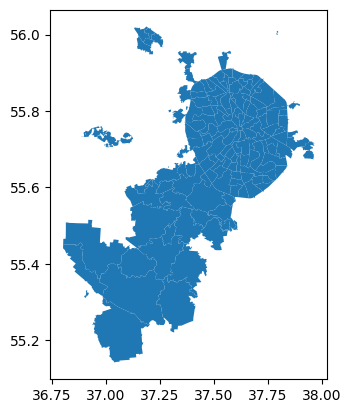

In [13]:
districts.plot();

In [14]:
districts['geometry'] = districts['geometry'].map(lambda polygon: shapely.ops.transform(lambda x, y: (y, x), polygon))

Подготовка координат для plotly:

In [15]:
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon

def geom2shape(geom):
    """
    Преобразование полигонов и мультиполигонов в plotly-readable шэйпы    
    
    Получает на вход Polygon или MultiPolygon из geopandas, 
    возвращает pd.Series с координатами x и y
    """
    type_geom = type(geom)  # проверяем тип объекта
    
    # Если мультиполигон, то преобразуем каждый полигон отдельно, разделяя их None'ами
    if type_geom == MultiPolygon:
        x, y = np.array([[], []])
        
        for poly in geom.geoms:
            xi, yi = poly.exterior.coords.xy
            x, y = np.append(x, xi), np.append(y, yi)  # np.append работает как list.append и list.extend
            x, y = np.append(x, None), np.append(y, None)  # в конце координат i-го полигона добавляем None, чтобы 
            
        x, y = x[:-1], y[:-1] # убираем лишний None
        
    # Если полигон, то просто извлекаем координаты
    elif type_geom == Polygon:
        x, y = np.array(geom.exterior.coords.xy)
        
    # Если что-то другое, то возвращаем пустые массивы
    else:
        x, y = np.array([[], []])
        
    return pd.Series([x, y])

In [16]:
districts[['x', 'y']] = districts['geometry'].apply(geom2shape)

Подсчет средней ЗП по МО:

In [17]:
data_coords = vacancies_df.loc[
    vacancies_df['address_lat'].notna() &
    vacancies_df['address_lng'].notna()
].reset_index(drop=True)
print(data_coords.shape)

(953, 9)


In [18]:
# сделаем Point
from shapely.geometry.point import Point

data_coords['coord'] = [Point(x, y) for x, y in data_coords[['address_lat', 'address_lng']].values.tolist()]

In [19]:
def map_point_to_mo(point: Point, sectors: list[str, Polygon|MultiPolygon]) -> str:
    districts = [district for district, sector in sectors if sector.contains(point)]

    if len(districts) == 0:
        return None
    else:
        districts[0]

In [20]:
data_coords['district'] = data_coords['coord'].map(lambda point: map_point_to_mo(point, districts[['NAME', 'geometry']].values.tolist()))

In [21]:
data_coords['district'].value_counts(dropna=False)

district
None    953
Name: count, dtype: int64

In [59]:
data_coords.head()

id  response_letter_required  salary_from  salary_to  \
0  88603203.0                       1.0          NaN    60000.0   
1  88587403.0                       0.0          NaN    70000.0   
2  88564624.0                       0.0      80000.0        NaN   
3  88602282.0                       0.0      74000.0    90000.0   
4  88381163.0                       0.0      70000.0    70000.0   

  salary_currency  salary_gross  address_lat  address_lng  \
0             RUR           1.0    55.746593    37.537371   
1             RUR           1.0    55.971663    37.491602   
2             RUR           0.0    55.803479    37.390514   
3             RUR           1.0    55.677930    37.562874   
4             RUR           1.0    55.747510    37.534954   

                                          key_skills  \
0                                  ['SQL', 'Python']   
1                                                 []   
2  ['SQL', 'Power BI', 'MS PowerPoint', 'Работа с...   
3                                                 []   
4  ['SQL', 'VBA', 'Математическая статистика', 'M...   

                         coord  
0  POINT (55.746593 37.537371)  
1  POINT (55.971663 37.491602)  
2  POINT (55.803479 37.390514)  
3   POINT (55.67793 37.562874)  
4   POINT (55.74751 37.534954)

In [55]:
districts

NAME     OKATO     OKTMO         NAME_AO  OKATO_AO  \
0            Киевский  45298555  45945000        Троицкий  45298000   
1      Филёвский Парк  45268595  45328000        Западный  45268000   
2     Новофёдоровское  45298567  45954000        Троицкий  45298000   
3           Роговское  45298575  45956000        Троицкий  45298000   
4        "Мосрентген"  45297568  45953000  Новомосковский  45297000   
..                ...       ...       ...             ...       ...   
141        Ивановское  45263567  45306000       Восточный  45263000   
142  Косино-Ухтомский  45263573  45308000       Восточный  45263000   
143        Новокосино  45263579  45310000       Восточный  45263000   
144        Некрасовка  45290574  45391000   Юго-Восточный  45290000   
145           Кунцево  45268562  45320000        Западный  45268000   

          ABBREV_AO              TYPE_MO  \
0          Троицкий            Поселение   
1               ЗАО  Муниципальный округ   
2          Троицкий            Поселение   
3          Троицкий            Поселение   
4    Новомосковский            Поселение   
..              ...                  ...   
141             ВАО  Муниципальный округ   
142             ВАО  Муниципальный округ   
143             ВАО  Муниципальный округ   
144            ЮВАО  Муниципальный округ   
145             ЗАО  Муниципальный округ   

                                              geometry  \
0    MULTIPOLYGON (((55.44083 36.80310, 55.44160 36...   
1    POLYGON ((55.74821 37.42765, 55.74875 37.42849...   
2    POLYGON ((55.45162 36.80357, 55.46551 36.80451...   
3    POLYGON ((55.24139 36.93724, 55.24161 36.93726...   
4    POLYGON ((55.62731 37.43956, 55.63042 37.44018...   
..                                                 ...   
141  POLYGON ((55.76232 37.79981, 55.76243 37.79981...   
142  POLYGON ((55.70978 37.83602, 55.71008 37.83620...   
143  POLYGON ((55.73049 37.84042, 55.73196 37.84063...   
144  POLYGON ((55.70626 37.90613, 55.70699 37.90701...   
145  MULTIPOLYGON (((55.80199 37.29050, 55.80300 37...   

                                                     x  \
0    [55.44083, 55.4416, 55.45162, 55.4514, 55.4513...   
1    [55.74821, 55.74875, 55.74939, 55.74976, 55.75...   
2    [55.45162, 55.46551, 55.46597, 55.47516, 55.48...   
3    [55.24139, 55.24161, 55.24195, 55.24225, 55.24...   
4    [55.62731, 55.63042, 55.63102, 55.63126, 55.63...   
..                                                 ...   
141  [55.76232, 55.76243, 55.76291, 55.76347, 55.76...   
142  [55.70978, 55.71008, 55.71068, 55.71312, 55.71...   
143  [55.73049, 55.73196, 55.74049, 55.74303, 55.74...   
144  [55.70626, 55.70699, 55.70761, 55.7078, 55.707...   
145  [55.80199, 55.803, 55.8032, 55.80335, 55.80345...   

                                                     y  
0    [36.8031, 36.80319, 36.80357, 36.81253, 36.827...  
1    [37.42765, 37.42849, 37.42958, 37.43058, 37.43...  
2    [36.80357, 36.80451, 36.81521, 36.81575, 36.81...  
3    [36.93724, 36.93726, 36.93755, 36.93794, 36.93...  
4    [37.43956, 37.44018, 37.44059, 37.44104, 37.44...  
..                                                 ...  
141  [37.79981, 37.79981, 37.79999, 37.80022, 37.80...  
142  [37.83602, 37.8362, 37.83653, 37.83777, 37.838...  
143  [37.84042, 37.84063, 37.84165, 37.84181, 37.84...  
144  [37.90613, 37.90701, 37.91925, 37.92067, 37.92...  
145  [37.2905, 37.29542, 37.29663, 37.29777, 37.298...  

[146 rows x 10 columns]

In [35]:
vacancies_restored.head()

id  response_letter_required    salary_from      salary_to  \
0  88603203.0                       1.0   40016.168839   60000.000000   
1  81879828.0                       0.0  261000.000000  391341.811433   
2  88629159.0                       0.0   37348.424250   56000.000000   
3  88587403.0                       0.0   46685.530312   70000.000000   
4  88564624.0                       0.0   80000.000000  119951.513083   

  salary_currency  salary_gross  address_lat  address_lng  \
0             RUR           1.0    55.746593    37.537371   
1             RUR           1.0          NaN          NaN   
2             RUR           1.0          NaN          NaN   
3             RUR           1.0    55.971663    37.491602   
4             RUR           0.0    55.803479    37.390514   

                                          key_skills  
0                                  ['SQL', 'Python']  
1                                                 []  
2                                                 []  
3                                                 []  
4  ['SQL', 'Power BI', 'MS PowerPoint', 'Работа с...

In [45]:
vacancies_df['salary_gross'].value_counts(dropna=False)

salary_gross
False    267
True     128
Name: count, dtype: int64

In [47]:
vacancies_df['experience'].value_counts(dropna=False)

experience
between1And3    208
between3And6     92
noExperience     80
moreThan6        15
Name: count, dtype: int64

In [49]:
skills = pd.Series([skill for lst in vacancies_df['key_skills'].dropna().tolist() for skill in lst])

In [50]:
skills.value_counts()

Аналитическое мышление                 98
SQL                                    66
Работа с большим объемом информации    58
Анализ данных                          57
MS Excel                               41
                                       ..
Информационная безопасность             1
trello                                  1
Документирование бизнес-требований      1
XML/XSD                                 1
postgre                                 1
Name: count, Length: 623, dtype: int64